In [182]:
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import math

(3008, 4112, 3)


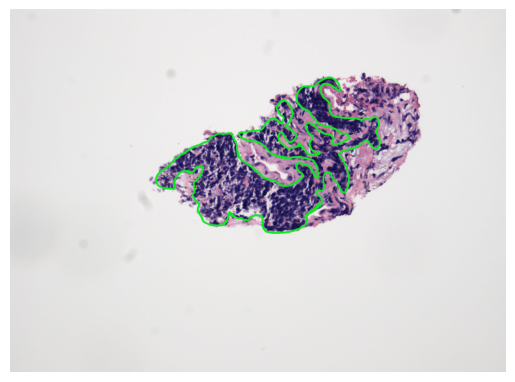

In [183]:
# Load the image
image_path = r'/home/pathway/mydisk/HIPT/data/non_mutated_green/green_outlined/21_20X_green.jpg'
img = cv2.imread(image_path)
print(img.shape)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

name = os.path.splitext(os.path.basename(image_path))[0]

In [184]:
name

'21_20X_green'

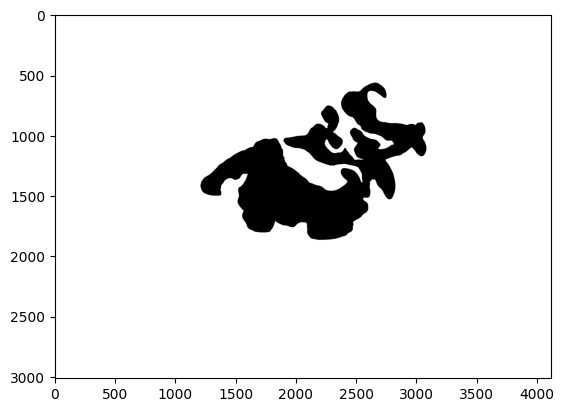

In [185]:
# Add a border to the image
border_size = 2
img = cv2.copyMakeBorder(img, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=[0, 0, 0])

# Step 2: Define the red region of interest using color segmentation
lower_red = np.array([0, 190, 0], dtype=np.uint8)
upper_red = np.array([100, 255, 100], dtype=np.uint8)
red_mask = cv2.inRange(img, lower_red, upper_red)

# Step 3: Apply the Canny edge detector to find edges within the red region
canny_edges = cv2.Canny(red_mask, 30, 30)  # You can adjust the parameters

# Step 4: Find contours in the Canny edges
contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 5: Create a binary mask for each contour and combine them
binary_mask = np.zeros_like(red_mask)
for contour in contours:
    cv2.drawContours(binary_mask, [contour], -1, 255, thickness=cv2.FILLED)
binary_mask = cv2.bitwise_not((binary_mask))
plt.imshow(binary_mask, cmap='gray')
# plt.axis('off')
plt.show()

In [186]:
def calculate_proportion_of_tumor_cells(mask):
    # count the number of white pixels (tumor cells) in the patch mask
    tumor_cells = np.sum(mask == 255)

    # count the total number of pixels
    total_pixels = mask.shape[0] * mask.shape[1]

    # calculate the proportion
    proportion = tumor_cells / total_pixels

    return proportion


def calculate_stride(image_width, image_height, patch_size):
    n_w = math.ceil(image_width / patch_size)
    n_h = math.ceil(image_height / patch_size)

    stride_w = (image_width - patch_size) // n_w
    stride_h = (image_height - patch_size) // n_h

    return stride_w, stride_h


def sliding_window_with_overlap(image, mask, window_size):

    img_width, img_height = image.shape[1], image.shape[0]
    # calculate the stride to be used
    stride_w, stride_h = calculate_stride(img_width, img_height, window_size)

    # Initialize a list to store the results
    results = []

    # Iterate over the image and mask
    for y in range(0, image.shape[0] - window_size + 1, stride_h):
        for x in range(0, image.shape[1] - window_size + 1, stride_w):

            # Extract the patch from the mask
            patch_mask = mask[y:y + window_size, x:x + window_size]

            # Calculate the proportion of white to black pixels in the mask patch
            proportion = calculate_proportion_of_tumor_cells(patch_mask)

            # Append the coordinates, proportion, and patch to the results
            results.append(((x, y), proportion))

    return results

In [187]:
window_size = 512

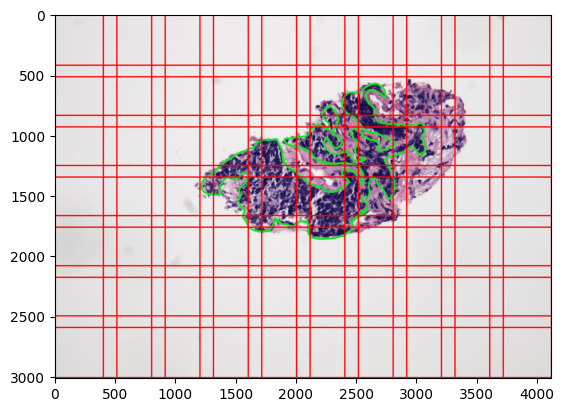

In [188]:
results = sliding_window_with_overlap(img, binary_mask, window_size=512)

for ((x, y), proportion) in results:
    cv2.rectangle(img, (x, y), (x + window_size, y + window_size), (0, 0, 255), 10)

# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [189]:
root_dir = r'/home/pathway/mydisk/HIPT/data'
folder_name = f'non_mutated_green/crop/{name[:5]}'

destn_dir = os.path.join(root_dir, folder_name, f'{window_size}')
os.makedirs(destn_dir, exist_ok = True)

# image_folder and mask folder for destination files
dest_img_dir = os.path.join(destn_dir, 'images')
dest_mask_dir = os.path.join(destn_dir, 'masks')
os.makedirs(dest_img_dir, exist_ok = True)
os.makedirs(dest_mask_dir, exist_ok = True)

cv2.imwrite(os.path.join(destn_dir, f'sliding_window_image.png'), img)

True

In [194]:
# read the real unedited image
real_img_path = r'/home/pathway/mydisk/HIPT/data/cancer'

# List the files in the directoryThe
real_image_files = os.listdir(real_img_path)

In [195]:
count = 0
with open(os.path.join(destn_dir, 'coordinates.txt'), 'w') as f:
    # write header
    f.write('Image filename, X, Y\n\n')
    
    for real_image_file in real_image_files:
        if real_image_file.startswith(name[:4]):
            real_image_dir = os.path.join(real_img_path, real_image_file)
            real_img = cv2.imread(real_image_dir)
            
            for ((x, y), proportion) in results:
                x1, x2 = x, x + window_size
                y1, y2 = y, y + window_size
                # common filename
                base_filename = f'{name[:6]}_{random.randint(1, 100000):08d}_{window_size}'
                
                img_patch = real_img[y : y + window_size, x : x + window_size]
                mask_patch = binary_mask[y : y + window_size, x : x + window_size]
                
                img_patch_name = f'{base_filename}_mutated_image_{proportion:.4f}.png'
                mask_patch_name = f'{base_filename}_mutated_mask_{proportion:.4f}.png'
                
                cv2.imwrite(os.path.join(dest_img_dir, img_patch_name), img_patch)
                cv2.imwrite(os.path.join(dest_mask_dir, mask_patch_name),  mask_patch)
                
                # write the information in the text file
                f.write(f'{base_filename}, {x}, {y}, {proportion}\n')
                
    f.write(f"\nCoordinates Length : {len(results)}\n")
print("Number of 512 images: ", len(results))

Number of 512 images:  70


In [181]:
name[:5]

'21_20'

## Change file Name

In [213]:
import os


directory_path = '/home/pathway/mydisk/HIPT/data/All_clean/non_mutated/images'

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    # Check if the filename contains the specific pattern we want to change
    if 'mutated_image' in filename:
        # Replace 'mutated_image' with 'non_mutated_image' in the filename
        new_filename = filename.replace('mutated_image', 'non_mutated_image')
        # Define the old and new file paths
        old_file = os.path.join(directory_path, filename)
        new_file = os.path.join(directory_path, new_filename)
        # Rename the file
        os.rename(old_file, new_file)
        print(f'Renamed "{filename}" to "{new_filename}"')

print('Renaming complete.')